# Histopathologic Cancer Detection

<a id='problem'></a>
# Problem
This notebook generates a submission to the https://www.kaggle.com/competitions/histopathologic-cancer-detection competition. The purpose is purely educational since the competition has long been finished.

The problem to solve is to identify the presence of cancer from a collection of unlabeled test images. To this aim we first develop a binary classification model from a labeled training dataset. Afterwards we use the trained model to generate predictions given the test dataset.

The steps in the notebook are the following:
1. [Brief description of the problem and dataset](#problem)
2. [Explority data analysis](#eda)
3. [Model architecture and reasoning for model](#model)
4. [Results and analysis](#results)
5. [Conclusion](#conclusion)

### Python packages used in this project

In [6]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sea
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.io import read_image

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl

### Dataset

The dataset is provided by the kaggle page https://www.kaggle.com/competitions/histopathologic-cancer-detection.

In [7]:
#DATA_ROOT = "/kaggle/input/histopathologic-cancer-detection"
DATA_ROOT = 'data'

TRAIN_PATH = f"{DATA_ROOT}/train"
TEST_PATH = f"{DATA_ROOT}/test"
TRAIN_LABELS = f"{DATA_ROOT}/train_labels.csv"

train_labels = pd.read_csv(TRAIN_LABELS, index_col='id')
train_data = glob.glob(f"{TRAIN_PATH}/*")
test_data = glob.glob(f"{TEST_PATH}/*")

assert(len(train_labels) == len(train_data))

N_TRAIN_NORMAL = len(train_labels[train_labels.label == 0])
N_TRAIN_CANCER = len(train_labels[train_labels.label == 1])

print(f"Number of normal training samples: {N_TRAIN_NORMAL}")
print(f"Number of cancerous training samples: {N_TRAIN_CANCER}")
print(f"Number of test samples (unknown labels): {len(test_data)}")

Number of normal training samples: 130908
Number of cancerous training samples: 89117
Number of test samples (unknown labels): 57458


In [8]:
train_labels.head()

,label
id,
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0


* As is evident, there are a total of __220,025 training images__, with 130,908 of those being noncancerous, and 89117 of those being cancerous. There are a total of __57458 unlabeled test images__.
* The __training dataset__ is labeled with either a __0 (noncancerous)__ or __1 (cancerous)__

In [9]:
# Helper functions to get the image id from the filename
# The image id is a unique id for each image (both train and test)

def get_id(filename):
    basename = os.path.basename(filename)
    return basename.split('.')[0]

def get_ids(filenames):
    return [get_id(filename) for filename in filenames]

get_ids(train_data[:5])

['955092a572cf9bb0a1fd54d638e17e3754a77795',
 '0c32f004eec2841e236f473a33254c112495c5ac',
 '862c8e345d3563f5bf0b0c2ca81ee37b35b14f94',
 '5522a46be9aa2148862858649d7c6766ab9325ac',
 'b2aa2dfa71915181db05f08ad255fbe27a80d499']

In [10]:
train_labels.loc[get_ids(train_data[:5])]

,label
id,
955092a572cf9bb0a1fd54d638e17e3754a77795,1
0c32f004eec2841e236f473a33254c112495c5ac,0
862c8e345d3563f5bf0b0c2ca81ee37b35b14f94,0
5522a46be9aa2148862858649d7c6766ab9325ac,1
b2aa2dfa71915181db05f08ad255fbe27a80d499,1


In [11]:
# Helper functions to return the label given the filename

def get_label(filename):
    return train_labels.loc[get_id(filename)].label

def get_labels(filenames):
    return train_labels.loc[get_ids(filenames)].label.values

print(get_label(train_data[0]))
print(get_labels(train_data[:3]))

1
[1 0 0]


<a id='eda'></a>
# EDA
## Visualization of Images
* Below I plot a number of random images from the dataset set to see if there is a noticable difference between the normal and pneumonia classes.
* I also plot the test dataset to see how different those images look

Text(0.5, 0.98, 'Test Images')

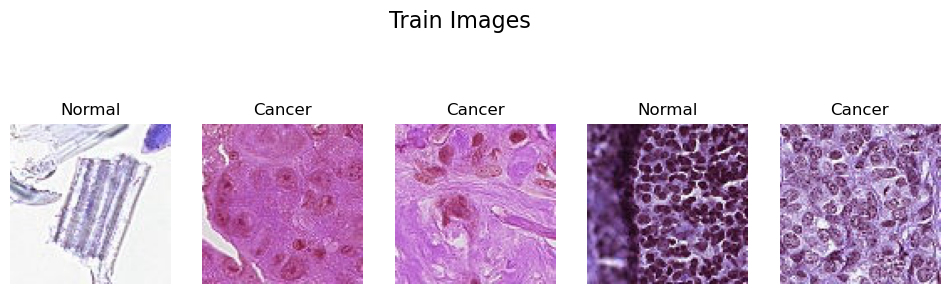

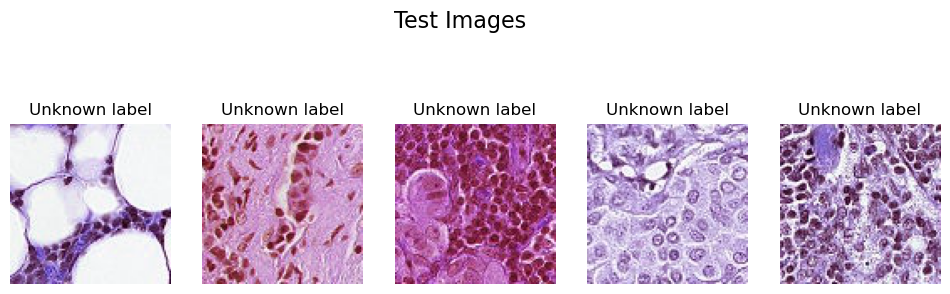

In [13]:
def plot_imgs(filenames, is_train, ncols=5):
    fig, axarr = plt.subplots(1, ncols, figsize=(12,4))

    imgs = random.sample(filenames, ncols)

    if is_train:
        labels = get_labels(imgs)

    for i in range(ncols):
        axarr[i].imshow(cv2.imread(imgs[i]))
        if is_train:
            if labels[i] == 0:
                axarr[i].set_title("Normal")
            else:
                axarr[i].set_title("Cancer")
        else:
            pass
            axarr[i].set_title("Unknown label")

        axarr[i].axis('off')

    return fig, axarr

fig1, _ = plot_imgs(train_data, True)
fig1.suptitle("Train Images", fontsize=16)

fig2, _ = plot_imgs(test_data, False)
fig2.suptitle("Test Images", fontsize=16)

### Observation
* It is difficult for an untrained eye to spot differences between the cancerous and noncancerous cells.
* The test images appear to be similar to the train images.

## Class Distribution

Text(0.5, 1.0, 'Test Dataset')

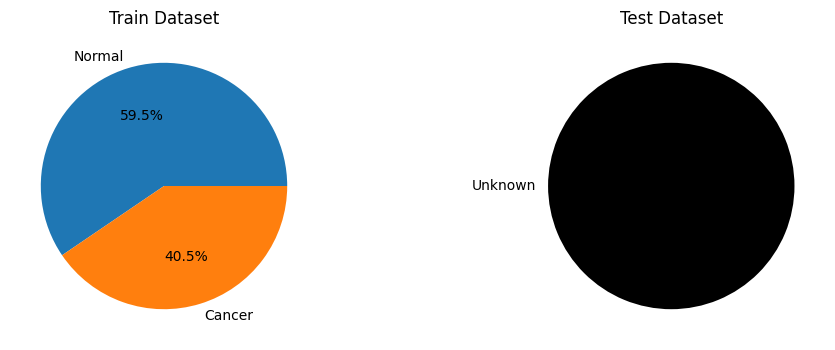

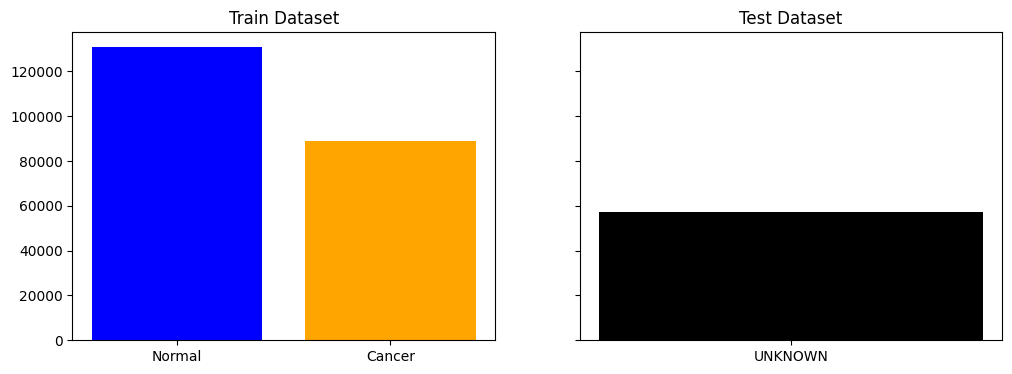

In [8]:
labels = ["Normal", "Cancer"]

fig, axarr = plt.subplots(1, 2, figsize=(12,4))

axarr[0].pie([N_TRAIN_NORMAL, N_TRAIN_CANCER], labels=labels, autopct='%1.1f%%')
axarr[0].set_title("Train Dataset")

axarr[1].pie([len(test_data)], labels=['Unknown'], colors=['black'], autopct='%1.1f%%')
axarr[1].set_title("Test Dataset")

fig, axarr = plt.subplots(1, 2, figsize=(12,4), sharey=True)

axarr[0].bar(labels, [N_TRAIN_NORMAL, N_TRAIN_CANCER], color=['blue', 'orange'])
axarr[0].set_title("Train Dataset")

axarr[1].bar(['UNKNOWN'], [len(test_data)], color=['black'])
axarr[1].set_title("Test Dataset")

### Observation
* We can see that there are more noncancerous images in the train dataset
* The test dataset is much smaller than the train dataset.

## Datacleaning

Various data cleaning techniques can be applied:
- **Class Imbalance:** Instead of augmenting the dataset for a more balanced distribution, we opt to adjust the weight assigned to each class during model learning. This adjustment will be demonstrated in the subsequent model training step.

- **Image Size:** Reshaping each image to a standard format, such as 224x224 pixels, is essential before inputting them into our classification models.

- **Normalization:** In the final step, we normalize the images to achieve a common practice of 0 mean and 1 standard deviation.

These data cleaning steps are executed during the data loading process and are implemented through a PyTorch transformation function defined below:



In [9]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((224, 224), antialias=True), # standard size for image models
                transforms.Normalize(mean = 0, std = 1)
            ])

## Custom PyTorch Dataset for Cancer Dataset

In order to efficiently handle a cancer dataset within the PyTorch framework, we've crafted a custom dataset class tailored to the specific nuances of our data. 

- **Data Loading:** The custom dataset class encapsulates the logic for loading data from the cancer dataset. In this case we use cv2 to load the images given their filename.

- **Labeling:** Using the given training labels, we can label the training images appropriately. The test images are arbitrarily labeled 0, however we don't use them. 

- **Preprocessing:** The dataset class applies the given transformation function to the images before returning them.


In [10]:
class CustomCancerDataset(Dataset):
    def __init__(self, filenames, is_train):
        self.filenames = filenames
        if is_train:
            self.labels = get_labels(filenames)
        else:
            self.labels = np.zeros(len(filenames))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img = cv2.imread(filename)
        img = transform(img)
        label = self.labels[idx]
        return img, label, filename

## Dataset Preparation

In the context of PyTorch Lightning, the groundwork for dataset interaction is laid through the abstract `LightningDataModule` class. To tailor it to our data, we need to override specific functions that serve as interfaces for data loading. These functions encompass:

- **train/val/test_dataloader:** These functions yield instances of the DataLoader class, facilitating the efficient loading of our training, validation, and test data in batches.

- **setup:** Executed at the outset, this function readies the data for loading. Within this step, our datasets are loaded using the custom dataset class defined above.

#### Validation Set

Given the absence of a designated validation set in our dataset, we resolve this by extracting 10% of the training set for validation purposes.

In [11]:
class DataModule(pl.LightningDataModule):

    def __init__(self, transform=transform, batch_size=32, num_workers=6):
        super().__init__()

        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):

        raw_train_dataset = CustomCancerDataset(train_data, is_train=True)
        n_train = int(0.9 * len(raw_train_dataset))
        n_val = len(raw_train_dataset) - n_train

        self.train_dataset, self.val_dataset = torch.utils.data.random_split(raw_train_dataset, [n_train, n_val])
        self.test_dataset = CustomCancerDataset(test_data, is_train=False)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

<a id='model'></a>

## Model Building

### Model Choice

We'll employ an EfficientNetV2_s transfer learning model for our task. This model involves replacing the final layer with two trainable fully connected layers. Transfer learning allows us to benefit from pre-existing model parameters trained on larger datasets, providing an upper bound on performance. EfficientNetV2_s is chosen for its efficiency and top-notch performance in image classification.

### Model Implementation

#### PyTorch Lightning Model

For model definition, we use PyTorch Lightning's `LightningModule`, which simplifies training and testing. Similar to the DataModule discussed earlier, we can override specific functions to customize our model. An abstract model is built to implement functions shared across all models in this notebook. Inheriting classes must define a feature extractor and a classifier. The feature extractor processes raw images and outputs features for the classifier, which in turn produces logits representing unnormalized class probabilities.

#### Optimizer

We'll employ the Adam optimizer due to its stability with varying initial learning rates. Additionally, a slight regularization is introduced by setting the weight_decay parameter to 1e-5.

#### Loss Function

For the classification problem at hand, the cross-entropy loss function is used as it is standard. To address class imbalance, more importance is assigned to normal classes by applying a factor of 2 through the weight parameter in the loss function.




In [12]:
class AbstractModel(LightningModule):

    def __init__(self, num_classes=2, lr=1e-3, weights=[2.0, 1.0], weight_decay=1e-5):
        super().__init__()

        # Inheriting classes implement these
        self.feature_extractor = None # ex. Base CNN or even a pretrained model
        self.classifier = None # ex. nn.Linear(num_filters, num_classes)

        self.lr = lr
        self.weight_decay=weight_decay
        self.num_classes = num_classes
        self.loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights))

        self.epoch_history = dict(
            train_loss=[],
            val_loss=[],
            train_acc=[],
            val_acc=[]
        )

        self.step_history = dict(
            train_loss=[],
            val_loss=[],
            train_acc=[],
            val_acc=[]
        )

    def forward(self, x):
        x = self.feature_extractor(x).flatten(1)
        x = self.classifier(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

    def _forward_step(self, batch):
        x, y, _ = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum() / len(y)
        return pred, loss, acc

    def training_step(self, batch, batch_idx):
        pred, loss, acc = self._forward_step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.step_history['train_loss'].append(loss)
        self.step_history['train_acc'].append(acc)
        return loss

    def validation_step(self, batch, batch_idx):
        pred, loss, acc = self._forward_step(batch)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True, logger=True)
        self.step_history['val_loss'].append(loss)
        self.step_history['val_acc'].append(acc)
        return loss

    def on_train_epoch_end(self):
        for key, value in self.step_history.items():
            if 'train' in key:
                self.epoch_history[key].append(torch.stack(value).mean().item())
                self.step_history[key].clear()
        #print(self.epoch_history)

    def on_validation_epoch_end(self):
        for key, value in self.step_history.items():
            if 'val' in key:
                self.epoch_history[key].append(torch.stack(value).mean().item())
                self.step_history[key].clear()
        #print(self.epoch_history)

In [13]:
class TransferLearningModel(AbstractModel):

    def __init__(self, base_model, n_in_features, num_classes=2, **kwargs):
        super().__init__(num_classes, **kwargs)

        #num_filters = base_model.fc.in_features

        layers = list(base_model.children())
        self.feature_extractor = nn.Sequential(*layers[:-1])

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        #num_filters = layers[-1].in_features
        n_out_features = 2 * n_in_features // 3 + 1

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(n_in_features, n_out_features),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(n_out_features, self.num_classes)
        )

In [14]:
class EfficientNet(TransferLearningModel):

    def __init__(self, num_classes=2, **kwargs):
        base_model = torchvision.models.efficientnet_v2_s(weights='DEFAULT')
        super().__init__(
            base_model,
            base_model.classifier[-1].in_features,
            num_classes,
            **kwargs
        )

## Model Training

* Hyperparameter tuning: ideally we would be performing hyperparameter tuning. However, due to computational demands and the robustness of the adam optimizer, we will select appropriate hyperparameters for training a single model.

In [15]:
lrs = [1e-3]
batch_sizes = [64]

from collections import namedtuple
from typing import List

class_map = dict(
    #CNN=ConvolutionalNetwork,
    #ResNet=ResNet,
    EfficientNet=EfficientNet
)

HyperParams = namedtuple("ModelKey", ["lr", "batch_size"])

# Maps to list of models with their hyperparams
model_map = dict(
    #CNN={},
    #ResNet={},
    EfficientNet={}
)

In [16]:
import itertools


#def get_checkpoint_file(model_type, lr, batch_size):
#    return f'models/{model_type}-lr{lr}-bs{batch_size}.ckpt'


torch.set_float32_matmul_precision('medium')

EPOCHS = 5
LOAD_CHECKPOINT = False
NUM_WORKERS=10

for lr, batch_size in itertools.product(lrs, batch_sizes):
    print(f"lr: {lr}, batch_size: {batch_size}")

    datamodule = DataModule(batch_size=batch_size, num_workers=NUM_WORKERS)
    datamodule.setup()

    for model_type, model_class in class_map.items():
        print(f"Training model: {model_type}")

        # Early stopping of model if validation loss doesn't decrease in 3 epochs
        trainer = pl.Trainer(
            max_epochs=EPOCHS,
            #default_root_dir=f'models/{model_type}',
            callbacks=[EarlyStopping(monitor="val_loss", mode="min")]
        )

        model = model_class(lr=lr)
        hyperparams = HyperParams(lr, batch_size)

        if hyperparams in model_map[model_type]:
            # Don't overwrite model
            continue

        #ckpt_path = get_checkpoint_file(model_type, lr, batch_size)

        #if LOAD_CHECKPOINT and os.path.exists(ckpt_path):
        #    trainer.fit(model, datamodule, ckpt_path=ckpt_path)
        #else:
        #    trainer.fit(model, datamodule)
        trainer.fit(model, datamodule)

        model_map[model_type][hyperparams] = model


lr: 0.001, batch_size: 64
Training model: EfficientNet


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | loss_fn           | CrossEntropyLoss | 0     
1 | feature_extractor | Sequential       | 20.2 M
2 | classifier        |

Sanity Checking: 0it [00:00, ?it/s]

/home/brian/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

/home/brian/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

/home/brian/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 51. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [17]:
best_models = {}

for model_type, models in model_map.items():
    print(f"{model_type}:")

    best_val_acc = 0
    best_hyperparams = None
    best_model = None

    for hyperparams, model in models.items():
        val_acc = model.epoch_history['val_acc'][-1]
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_hyperparams = hyperparams
            best_model = model

    print(f"  best val acc: {best_val_acc:0.3f}, lr: {hyperparams.lr}, batch_size: {hyperparams.batch_size}")

    best_models[model_type] = (model, hyperparams)
    torch.save(model.state_dict(), f'BEST_{model_type}.pt')

EfficientNet:
  best val acc: 0.849, lr: 0.001, batch_size: 64


<a id='results'></a>

## Results Analysis

The analysis will proceed as follows:

1. **Training Progress Plot:**
   We will visualize the training and validation curves obtained during the training process. This plot will illustrate the model's improvement over time.

2. **Test Dataset Evaluation:**
   Using the test dataset, we will assess our model's predictions. This step requires submitting the generated predictions to the kaggle page to get an aggregated prediction score.



###  Plot Train/Validation Curves
   * The cross-entropy loss and prediction accuracy is plotted below for each of the selected models.



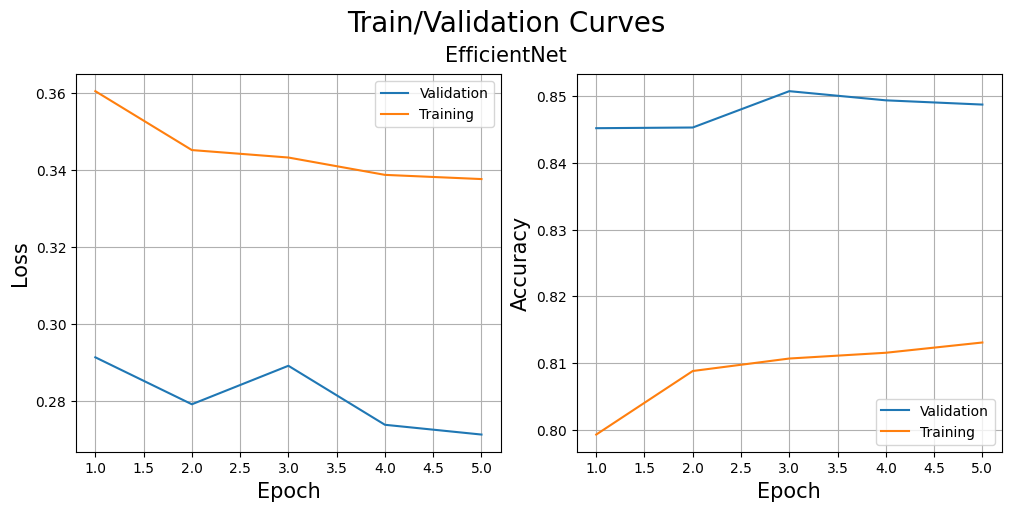

In [37]:
fig = plt.figure(constrained_layout=True, figsize=(10,5))
fig.suptitle('Train/Validation Curves', fontsize=20)

row_mapping = {
    i: model_type for i, model_type in enumerate(best_models.keys())
}

subfigs = fig.subfigures(nrows=len(best_models), ncols=1)

if not isinstance(subfigs, list):
    subfigs = [subfigs]

for row, subfig in enumerate(subfigs):
    
    model_type = row_mapping[row]
    
    subfig.suptitle(model_type, fontsize=15)
    
    axs = subfig.subplots(nrows=1, ncols=2)
    model = best_models[model_type][0]
    
    train_loss = model.epoch_history['train_loss']
    train_acc = model.epoch_history['train_acc']
    nepochs = len(train_loss)
    
    val_loss = model.epoch_history['val_loss'][-nepochs:]
    val_acc = model.epoch_history['val_acc'][-nepochs:]
    
    epochs = range(1, nepochs+1)
    
    axs[0].set_ylabel("Loss", fontsize=15)
    axs[1].set_ylabel("Accuracy", fontsize=15)
    axs[0].set_xlabel("Epoch", fontsize=15)
    axs[1].set_xlabel("Epoch", fontsize=15)
    
    # TEMP
    #train_loss, train_acc = val_loss, val_acc
    
    axs[0].plot(epochs, val_loss, label='Validation')
    axs[0].plot(epochs, train_loss, label='Training')
    
    axs[1].plot(epochs, val_acc, label='Validation')
    axs[1].plot(epochs, train_acc, label='Training')
    
    for ax in axs:
        ax.grid()
        ax.legend()

* It appears that the validation score peaked at epoch 3 at a maximum of ~0.85.

### Predictions

In [19]:
from tqdm import tqdm

In [21]:
test_dataloader = DataLoader(
                      datamodule.test_dataset, batch_size=128, num_workers=2
                  )

for model_type, model_tuple in best_models.items():
    print(f"{model_type}:")
    model = model_tuple[0]

    #trainer.test(model, datamodule)#, ckpt_path=get_checkpoint_file(model_type))

    device = torch.device("cpu")   #"cuda:0"
    model.eval()

    y_pred=[]
    ids = []

    with torch.no_grad():
        for test_imgs, _, test_fnames in tqdm(test_dataloader):
            pred = model(test_imgs).argmax(dim=1).to(device)
            for i in range(len(pred)):
                y_pred.append(pred[i].item())
                ids.append(get_id(test_fnames[i]))

EfficientNet:


100%|█████████████████████████████████████████| 449/449 [43:43<00:00,  5.84s/it]


In [28]:
output_df = pd.DataFrame(dict(id=ids, label=y_pred))
#output_df.head()
output_df.to_csv("submission.csv", index=False)

* After submitting the csv file to kaggle, we get a __prediction score of 0.8005__.

<a id='conclusion'></a>
# Discussion and Conclusion
* We training a binary classification model to classify cancer images. The model we selected was a modified EfficientNet with transfer learning. The validation accuracy was 0.85 and the test score was 0.80.
* The dataset suffers from class imbalance, with there being roughly twice as many normal train images than cancerous ones. 
* We did not employ hyperparameter tuning due to computational constraints, and we chose the batch size to be 64 and learning rate to be 1e-3.
* To improve upon our results there are several suggested steps:
  1. Explore other models: We could have modified the trainable layers in the EfficientNet to increase the trainable weights. This may have led to a higher validation accuracy peak. Similarly, we could have unfrozen the pretrained layers and allowed them to be trained.
  2. Class imbalance: We could have carefully chosen the training and validation sets to ensure they have the appropriate amounts of normal/cancerous images.
  3. Hyperparameter tuning: We did not employ this so any amount of hyperparameter tuning would be an improvement.